In [284]:
# General use libraries
import numpy as np
import os
import pandas as pd
from joblib import dump, load

# Set numpy and pandas options for viewing
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option('max_colwidth',1000)
pd.options.display.max_info_columns = 999
pd.set_option('expand_frame_repr',True)

# Data Visualization Libaries
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style

# keras and sklearn for machine learning 
import keras
import lightgbm as lgb
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.utils import np_utils
from keras import backend as K
from sklearn.model_selection import cross_validate, GridSearchCV, KFold, train_test_split, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn import tree, svm
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel

In [3]:
#import data into a dataframe
train = pd.read_csv('all/train.csv', sep = ",", header=0)
test = pd.read_csv('all/test.csv', sep = ",", header=0)
meta = pd.read_csv('all/metadata.csv',index_col='Variable', header=0)
print(f'Train data:{train.shape}, Test data: {test.shape}, Metadata: {meta.shape}')

#create combined dataframe to ensure one-hot encoding columns is aligned
combined = pd.concat([train, test], axis=0, sort=False)

Train data:(1460, 81), Test data: (1459, 80), Metadata: (80, 1)


In [4]:
# show first 5 rows of training set
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
# show descriptions of numerical fields of training set
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [6]:
# show first 5 rows of test set
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [7]:
# show descriptions of numerical fields of test set
test.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1459.000000,1232.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,1458.000000,1458.000000,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1457.000000,1457.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.00000,1381.000000,1458.000000,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,2190.000000,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,52.619342,554.294925,1046.117970,1156.534613,325.967786,3.543523,1486.045922,0.434454,0.065202,1.570939,0.377656,2.854010,1.042495,6.385195,0.58122,1977.721217,1.766118,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,421.321334,42.746880,22.376841,4955.517327,1.436812,1.113740,30.390071,21.130467,177.625900,455.268042,176.753926,437.260486,442.898624,398.165820,420.610226,44.043251,485.566099,0.530648,0.252468,0.555190,0.503017,0.829788,0.208472,1.508895,0.64742,26.431175,0.775945,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,1461.000000,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,407.000000,0.000000,0.000000,407.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.00000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,1825.500000,20.000000,58.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,0.000000,219.250000,784.000000,873.500000,0.000000,0.000000,1117.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.00000,1959.000000,1.000000,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,2190.000000,50.000000,67.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.500000,0.000000,460.000000,988.000000,1079.000000,0.000000,0.000000,1432.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,0.00000,1979.000000,2.000000,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2554.500000,70.000000,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,164.000000,753.500000,0.000000,797.750000,1305.000000,1382.500000,676.000000,0.000000,1721.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.00000,2002.000000,2.000000,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2919.000000,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,1526.000000,2140.000000,5095.000000,5095.000000,1862.000000,1064.000000,5095.000000,3.000000,2.000000,4.000000,2.000000,6.000000,2.000000,15.000000,4.00000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


In [8]:
# check for train data outliers
train_outlier = train.describe().loc['max'][(train.describe().loc['max'] > 
                                             (train.describe().loc['mean'] + 10 * train.describe().loc['std'])) == True][train.describe().loc['max']>1]

In [9]:
# check for test data outliers
test_outlier = test.describe().loc['max'][(test.describe().loc['max'] > 
                                           (test.describe().loc['mean'] + 10 * test.describe().loc['std'])) == True][test.describe().loc['max']>1]

In [10]:
# show outliers in training set
train_outlier

LotFrontage        313.0
LotArea         215245.0
BsmtFinSF1        5644.0
TotalBsmtSF       6110.0
LowQualFinSF       572.0
3SsnPorch          508.0
PoolArea           738.0
MiscVal          15500.0
Name: max, dtype: float64

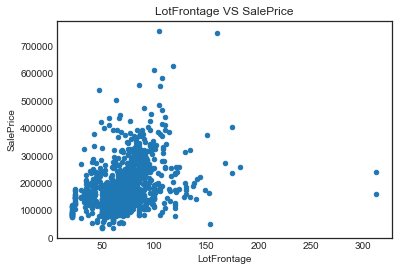

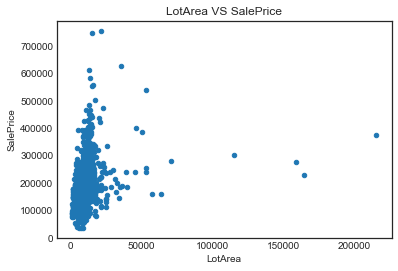

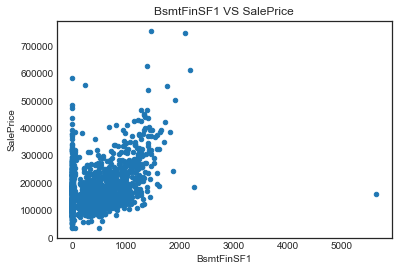

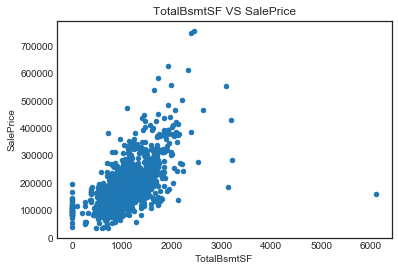

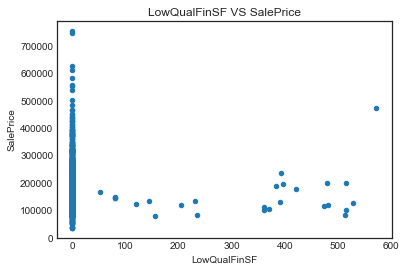

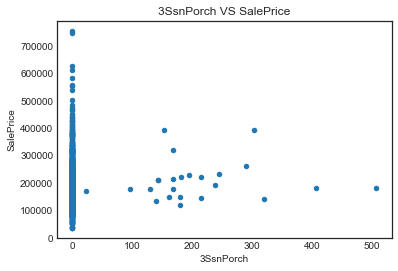

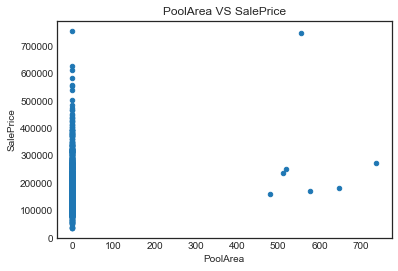

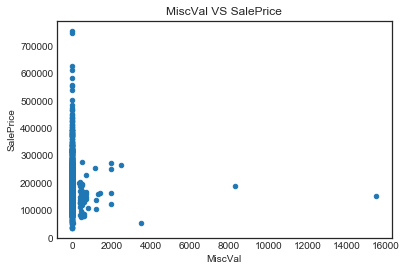

In [12]:
# plot outliers against Target
style.use('seaborn-white')
for item in train_outlier.index:
    train.plot(kind='scatter', x=item, y = 'SalePrice', title = f'{item} VS SalePrice')

In [13]:
# show outliers in test set
test_outlier

LowQualFinSF      1064.0
WoodDeckSF        1424.0
OpenPorchSF        742.0
EnclosedPorch     1012.0
3SsnPorch          360.0
PoolArea           800.0
MiscVal          17000.0
Name: max, dtype: float64

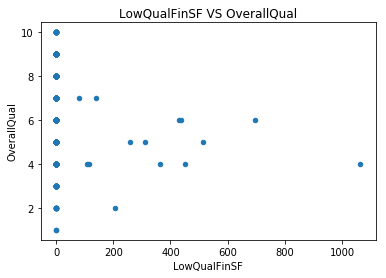

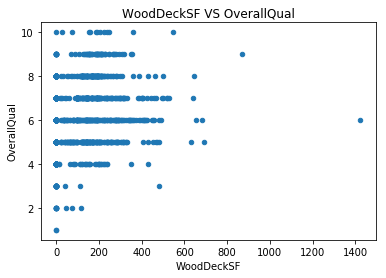

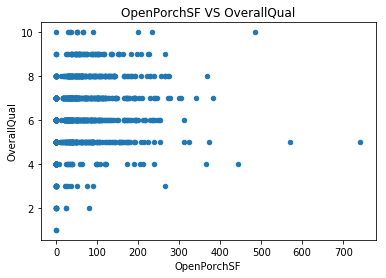

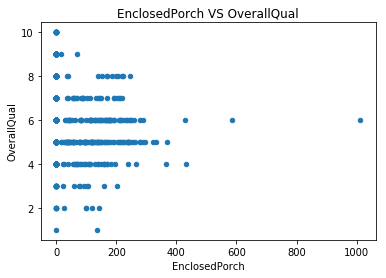

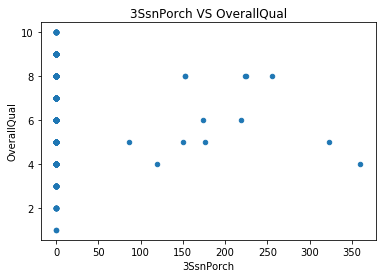

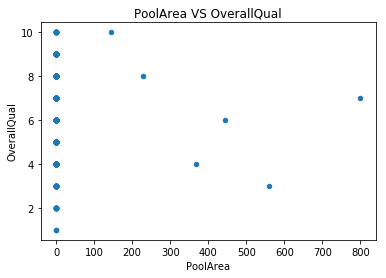

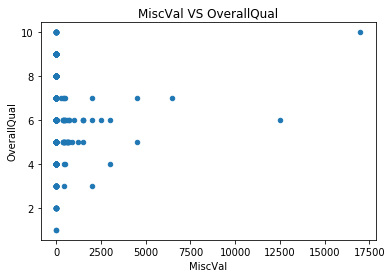

In [11]:
# plot outliers against OverallQual, which has the highest correlation with Target in Training set
for item in test_outlier.index:
    test.plot(kind='scatter', x=item, y = 'OverallQual', title = f'{item} VS OverallQual')

While there are outliers in the train and test datasets, they do not seem to be a mistake from the scatters, and thus will be left untreated to avoid removing useful sources of data.

In [13]:
# show metadata
print(meta.info())
meta

<class 'pandas.core.frame.DataFrame'>
Index: 80 entries, SalePrice to SaleCondition
Data columns (total 1 columns):
Definition    80 non-null object
dtypes: object(1)
memory usage: 3.8+ KB
None


,Definition
Variable,
SalePrice,The Property's Sale Price In Dollars
MSSubClass,The Building Class
MSZoning,The General Zoning Classification
LotFrontage,Linear Feet Of Street Connected To Property
LotArea,Lot Size In Square Feet
Street,Type Of Road Access
Alley,Type Of Alley Access
LotShape,General Shape Of Property
LandContour,Flatness Of The Property


In [14]:
# check how data is structured + datatypes
print('Train')
print(train.info(),'\n')
print('Test')
print(test.info())

Train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460

In [21]:
# check for duplicates
print(f'Train duplicates: {len(train[train.duplicated()])}\nTest Duplicates: {len(test[test.duplicated()])}')

Train duplicates: 0
Test Duplicates: 0


In [15]:
# print out columns with null values, and total number of columns with null values
null_train = train.isnull().sum()[train.isnull().sum()>0]
null_test = test.isnull().sum()[test.isnull().sum()>0]
print(f'Train:\n{null_train}\nTotal # of columns:{len(null_train)}\n')
print(f'Test:\n{null_test}\nTotal # of columns:{len(null_test)}\n')

# place columns into dataframe for easier viewing
tr_null = pd.DataFrame.from_dict(dict(null_train), orient= 'index', columns = ['Train'])
te_null = pd.DataFrame.from_dict(dict(null_test), orient= 'index', columns = ['Test'])
null_df = pd.concat([tr_null, te_null], axis = 1, sort=False)
print(null_df.head())

# show which columns have null values
print('Definitions:')
for item in null_df.index:
    print(f'{item}\n{meta.loc[item]}\n')

Train:
LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64
Total # of columns:19

Test:
MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageYrBlt       78
GarageFinish      78
GarageCars         1
Garage

In [16]:
# fill na for null_df
null_df.fillna(0, inplace=True)

In [17]:
# set up significance col to calculate missing percentage
null_df = null_df.assign(Missing_Perc = (null_df.Train+null_df.Test)/(len(train)+len(test)))

In [18]:
# show null_df
null_df

,Train,Test,Missing_Perc
LotFrontage,259.0,227.0,0.166495
Alley,1369.0,1352.0,0.932169
MasVnrType,8.0,16.0,0.008222
MasVnrArea,8.0,15.0,0.007879
BsmtQual,37.0,44.0,0.027749
BsmtCond,37.0,45.0,0.028092
BsmtExposure,38.0,44.0,0.028092
BsmtFinType1,37.0,42.0,0.027064
BsmtFinType2,38.0,42.0,0.027407
Electrical,1.0,0.0,0.000343


In [28]:
# Slice data into X and Y dataframes
X = combined.iloc[:,:-1]
y = combined.iloc[:,-1]

In [29]:
# replace nan values with 0
X.fillna(0, inplace = True)

In [30]:
# Check number of rows to extract later
Tr_rows = train.shape[0]
Test_rows = test.shape[0]
print([Tr_rows, Test_rows])

[1460, 1459]


In [31]:
# Classify categorical variables
cat_var = ['Id']

for i in range(X.shape[1]):
    if type(X.iloc[:,i].unique()[0]) == str:
        cat_var.append(X.columns[i])
    elif type(X.iloc[:,i].unique()[1]) == str:
        cat_var.append(X.columns[i])
    elif type(X.iloc[:,i].unique()[2]) == str:
        cat_var.append(X.columns[i])
    #elif len(X.iloc[:,i].unique())<=200:
        #cat_var.append(X.columns[i])

In [32]:
# manually remove some variables that are not actually categorical
for item in cat_var: 
    try:
        print(item, '\n')
        print(meta.loc[item], '\n')
    except: 
        pass
        print('no such item in dataframe!\n')

Id 

no such item in dataframe!

MSZoning 

Definition    The General Zoning Classification
Name: MSZoning, dtype: object 

Street 

Definition    Type Of Road Access
Name: Street, dtype: object 

Alley 

Definition    Type Of Alley Access
Name: Alley, dtype: object 

LotShape 

Definition    General Shape Of Property
Name: LotShape, dtype: object 

LandContour 

Definition    Flatness Of The Property
Name: LandContour, dtype: object 

Utilities 

Definition    Type Of Utilities Available
Name: Utilities, dtype: object 

LotConfig 

Definition    Lot Configuration
Name: LotConfig, dtype: object 

LandSlope 

Definition    Slope Of Property
Name: LandSlope, dtype: object 

Neighborhood 

Definition    Physical Locations Within Ames City Limits
Name: Neighborhood, dtype: object 

Condition1 

Definition    Proximity To Main Road Or Railroad
Name: Condition1, dtype: object 

Condition2 

Definition    Proximity To Main Road Or Railroad (If A Second Is Present)
Name: Condition2, dtype: obj

In [33]:
# remove actual numerical variables
for item in ['LotFrontage','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea']:
    try:
        cat_var.remove(item)
        print(item, '\n')
    except:
        pass
        print('item not in list! \n')

item not in list! 

item not in list! 

item not in list! 

item not in list! 

item not in list! 



In [34]:
# separate categorical and numerical data
X_cat = X.loc[:,cat_var]
cat_var.remove('Id')
X_num = X.drop(columns=cat_var, inplace = False)

In [35]:
# show shape of X_cat and X_num
print([X_cat.shape, X_num.shape])

[(2919, 44), (2919, 37)]


In [37]:
#Apply one-hot encoding to all cat_var
X_cat_enc = pd.get_dummies(X_cat)
X_cat_enc.head()

,Id,MSZoning_0,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_0,Alley_Grvl,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_0,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_0,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_0,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_0,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_0,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_0,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_0,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_0,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_0,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_0,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_0,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_0,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_0,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_0,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_0,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_0,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_0,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,PoolQC_0,PoolQC_Ex,PoolQC

In [38]:
print([X_cat_enc.shape])

[(2919, 276)]


In [39]:
#merge categorical and numerical dataframes
X_new = pd.concat([X_cat_enc, X_num], axis=1)
print(X_new.shape)
X_new.head()

(2919, 313)


,Id,MSZoning_0,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_0,Alley_Grvl,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_0,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_0,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_0,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_0,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_0,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_0,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_0,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_0,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_0,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_0,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_0,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_0,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_0,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_0,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_0,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_0,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_0,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,PoolQC_0,PoolQC_Ex,PoolQC

C:\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


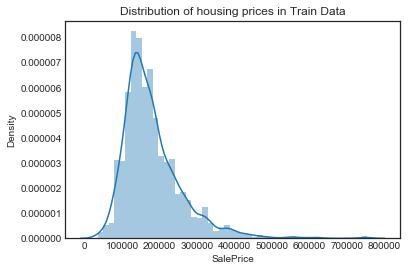

In [40]:
# plot distribution of Target in train dataset
style.use('seaborn-white')
sns.distplot(train.SalePrice, kde=True, norm_hist = True)
plt.ylabel('Density')
plt.title('Distribution of housing prices in Train Data')
plt.show()

In [41]:
# change all datatypes to floats
X_new = X_new.astype('float64', errors = 'ignore')

In [42]:
# show X_new datatypes for verification
X_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 313 columns):
Id                       2919 non-null float64
MSZoning_0               2919 non-null float64
MSZoning_C (all)         2919 non-null float64
MSZoning_FV              2919 non-null float64
MSZoning_RH              2919 non-null float64
MSZoning_RL              2919 non-null float64
MSZoning_RM              2919 non-null float64
Street_Grvl              2919 non-null float64
Street_Pave              2919 non-null float64
Alley_0                  2919 non-null float64
Alley_Grvl               2919 non-null float64
Alley_Pave               2919 non-null float64
LotShape_IR1             2919 non-null float64
LotShape_IR2             2919 non-null float64
LotShape_IR3             2919 non-null float64
LotShape_Reg             2919 non-null float64
LandContour_Bnk          2919 non-null float64
LandContour_HLS          2919 non-null float64
LandContour_Low          2919 non-null float64

In [43]:
# Separate back into train and test 
tr_X = X_new[:Tr_rows]
tr_y = y[:Tr_rows]
te_X = X_new[Tr_rows:]
print(f'Shape of tr_X: {tr_X.shape}\nShape of y: {tr_y.shape}\nShape of Te_X:{te_X.shape}')

Shape of tr_X: (1460, 313)
Shape of y: (1460,)
Shape of Te_X:(1459, 313)


In [44]:
# combine tr_X and tr_y to check correlation
df = pd.concat([tr_X, tr_y], axis = 1)
df.head()

,Id,MSZoning_0,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_0,Alley_Grvl,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_0,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_0,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_0,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_0,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_0,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_0,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_0,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_0,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_0,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_0,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_0,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_0,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_0,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_0,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_0,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_0,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_0,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,PoolQC_0,PoolQC_Ex,PoolQC

In [45]:
# check correlation of features
tr_corr = df.corr()

sorted_cor = tr_corr['SalePrice'][tr_corr['SalePrice'].isna()==False].sort_values(ascending=False)
print(f'Most Positive Correlations:\n{sorted_cor.head(20)}\n\nMost Negative Correlations:\n{sorted_cor.tail(20)}')

Most Positive Correlations:
SalePrice           1.000000
OverallQual         0.790982
GrLivArea           0.708624
GarageCars          0.640409
GarageArea          0.623431
TotalBsmtSF         0.613581
1stFlrSF            0.605852
FullBath            0.560664
BsmtQual_Ex         0.553105
TotRmsAbvGrd        0.533723
YearBuilt           0.522897
YearRemodAdd        0.507101
KitchenQual_Ex      0.504094
Foundation_PConc    0.497734
MasVnrArea          0.472614
Fireplaces          0.466929
ExterQual_Gd        0.452466
ExterQual_Ex        0.451164
BsmtFinType1_GLQ    0.434597
HeatingQC_Ex        0.434543
Name: SalePrice, dtype: float64

Most Negative Correlations:
PavedDrive_N        -0.212630
RoofStyle_Gable     -0.224744
GarageFinish_0      -0.236832
GarageQual_0        -0.236832
GarageCond_0        -0.236832
GarageType_0        -0.236832
SaleType_WD         -0.242598
CentralAir_N        -0.251328
BsmtExposure_No     -0.263600
LotShape_Reg        -0.267672
MSZoning_RM         -0.288065
H

In [131]:
# turn X into an array
X_arr = tr_X.iloc[:,1:].values
y_arr = tr_y.values
te_X_arr = te_X.iloc[:,1:].values
print(f'Shape of X_arr: {X_arr.shape}\nShape of te_X_arr:{te_X_arr.shape}')

Shape of X_arr: (1460, 312)
Shape of te_X_arr:(1459, 312)


In [132]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
X_arr = scaler.fit_transform(X_arr)
te_X_arr = scaler.fit_transform(te_X_arr)
# y_arr = np.log(y_arr)

In [133]:
# Show X_arr and te_X
np.append(X_arr, te_X_arr, axis=0)

array([[0.        , 0.        , 0.        , ..., 0.        , 0.09090909,
        0.5       ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.36363636,
        0.25      ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.72727273,
        0.5       ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.72727273,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.04117647, 0.54545455,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.90909091,
        0.        ]])

In [135]:
# show y
y_arr

array([208500., 181500., 223500., ..., 266500., 142125., 147500.])

In [136]:
assert not np.any(np.isnan(X_arr))

In [137]:
assert not np.any(np.isnan(y_arr))

In [138]:
# Check shape of array
print(f'Shape of X_arr: {X_arr.shape}\nShape of Te_X:{te_X_arr.shape}')

Shape of X_arr: (1460, 312)
Shape of Te_X:(1459, 312)


In [139]:
#set up dimensions for algorithm
num_dim = X_arr.shape[1]
output_dim = 1
print("First layer dimension = {}. Last layer dimension = {}.".format(num_dim, output_dim))

First layer dimension = 312. Last layer dimension = 1.


# Set up different ML methods

Submit individual predictions and compare performance across different methods. 

# Neural Network

### NN score = 0.30

In [113]:
# define metric for neural network
def rmsle_nn(y_true, y_pred):    
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)    
    return K.sqrt(K.mean(K.square(first_log - second_log), axis=-1))

In [333]:
# create 1-layer model (score = 0.17141)
def baseline_model():
    model = Sequential()
    model.add(Dense(num_dim, input_dim=num_dim, kernel_initializer='normal', activation='relu'))
    model.add(Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(Dense(output_dim, activation='linear'))
    
    model.compile(loss=rmsle_nn, optimizer='adam', metrics=['mae'])
    return model

In [334]:
#show model summary
model = baseline_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_265 (Dense)            (None, 312)               97656     
_________________________________________________________________
dense_266 (Dense)            (None, 100)               31300     
_________________________________________________________________
dense_267 (Dense)            (None, 1)                 101       
Total params: 129,057
Trainable params: 129,057
Non-trainable params: 0
_________________________________________________________________


In [335]:
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=100, verbose=1)

In [336]:
#k-fold cross validation
kfold = KFold(n_splits=5)
results = cross_validate(estimator, X_arr, tr_y, cv=kfold, verbose = 0, return_train_score=True)

Epoch 1/100
1168/1168 [==============================] - 7s 6ms/step - loss: 10.5515 - mean_absolute_error: 180712.6499
Epoch 2/100
1168/1168 [==============================] - 0s 56us/step - loss: 8.7939 - mean_absolute_error: 180691.2915
Epoch 3/100
1168/1168 [==============================] - 0s 54us/step - loss: 7.8100 - mean_absolute_error: 180649.0324
Epoch 4/100
1168/1168 [==============================] - 0s 55us/step - loss: 7.1636 - mean_absolute_error: 180587.7912
Epoch 5/100
1168/1168 [==============================] - 0s 55us/step - loss: 6.6863 - mean_absolute_error: 180508.9438
Epoch 6/100
1168/1168 [==============================] - 0s 54us/step - loss: 6.3064 - mean_absolute_error: 180413.0870
Epoch 7/100
1168/1168 [==============================] - 0s 54us/step - loss: 5.9903 - mean_absolute_error: 180300.2198
Epoch 8/100
1168/1168 [==============================] - 0s 53us/step - loss: 5.7187 - mean_absolute_error: 180170.2227
Epoch 9/100
1168/1168 [=================

1168/1168 [==============================] - 0s 52us/step - loss: 1.2271 - mean_absolute_error: 131929.3705
Epoch 69/100
1168/1168 [==============================] - 0s 53us/step - loss: 1.1948 - mean_absolute_error: 130322.5716
Epoch 70/100
1168/1168 [==============================] - 0s 56us/step - loss: 1.1629 - mean_absolute_error: 128689.1634
Epoch 71/100
1168/1168 [==============================] - 0s 50us/step - loss: 1.1315 - mean_absolute_error: 127026.4869
Epoch 72/100
1168/1168 [==============================] - 0s 55us/step - loss: 1.1006 - mean_absolute_error: 125336.6854
Epoch 73/100
1168/1168 [==============================] - 0s 56us/step - loss: 1.0701 - mean_absolute_error: 123614.0563
Epoch 74/100
1168/1168 [==============================] - 0s 57us/step - loss: 1.0401 - mean_absolute_error: 121870.6909
Epoch 75/100
1168/1168 [==============================] - 0s 56us/step - loss: 1.0106 - mean_absolute_error: 120103.5068
Epoch 76/100
1168/1168 [=====================

1168/1168 [==============================] - 0s 54us/step - loss: 3.1068 - mean_absolute_error: 172947.5310
Epoch 36/100
1168/1168 [==============================] - 0s 55us/step - loss: 3.0479 - mean_absolute_error: 172494.6681
Epoch 37/100
1168/1168 [==============================] - 0s 54us/step - loss: 2.9905 - mean_absolute_error: 172027.0450
Epoch 38/100
1168/1168 [==============================] - 0s 53us/step - loss: 2.9346 - mean_absolute_error: 171545.2955
Epoch 39/100
1168/1168 [==============================] - 0s 51us/step - loss: 2.8801 - mean_absolute_error: 171049.2188
Epoch 40/100
1168/1168 [==============================] - 0s 54us/step - loss: 2.8270 - mean_absolute_error: 170538.5437
Epoch 41/100
1168/1168 [==============================] - 0s 53us/step - loss: 2.7751 - mean_absolute_error: 170012.7831
Epoch 42/100
1168/1168 [==============================] - 0s 54us/step - loss: 2.7244 - mean_absolute_error: 169472.7215
Epoch 43/100
1168/1168 [=====================

1168/1168 [==============================] - 3s 2ms/step - loss: 10.7852 - mean_absolute_error: 180004.2341
Epoch 2/100
1168/1168 [==============================] - 0s 56us/step - loss: 9.0776 - mean_absolute_error: 179988.1292
Epoch 3/100
1168/1168 [==============================] - 0s 58us/step - loss: 8.0521 - mean_absolute_error: 179954.1016
Epoch 4/100
1168/1168 [==============================] - 0s 56us/step - loss: 7.3853 - mean_absolute_error: 179903.9987
Epoch 5/100
1168/1168 [==============================] - 0s 56us/step - loss: 6.8996 - mean_absolute_error: 179839.5447
Epoch 6/100
1168/1168 [==============================] - 0s 55us/step - loss: 6.5158 - mean_absolute_error: 179761.1444
Epoch 7/100
1168/1168 [==============================] - 0s 56us/step - loss: 6.1968 - mean_absolute_error: 179668.7026
Epoch 8/100
1168/1168 [==============================] - 0s 56us/step - loss: 5.9220 - mean_absolute_error: 179561.6056
Epoch 9/100
1168/1168 [=============================

1168/1168 [==============================] - 0s 58us/step - loss: 1.3887 - mean_absolute_error: 138530.5467
Epoch 69/100
1168/1168 [==============================] - 0s 59us/step - loss: 1.3546 - mean_absolute_error: 137090.7564
Epoch 70/100
1168/1168 [==============================] - 0s 56us/step - loss: 1.3210 - mean_absolute_error: 135618.6946
Epoch 71/100
1168/1168 [==============================] - 0s 55us/step - loss: 1.2878 - mean_absolute_error: 134118.3504
Epoch 72/100
1168/1168 [==============================] - 0s 54us/step - loss: 1.2549 - mean_absolute_error: 132584.6393
Epoch 73/100
1168/1168 [==============================] - 0s 56us/step - loss: 1.2224 - mean_absolute_error: 131016.3638
Epoch 74/100
1168/1168 [==============================] - 0s 55us/step - loss: 1.1903 - mean_absolute_error: 129415.8070
Epoch 75/100
1168/1168 [==============================] - 0s 55us/step - loss: 1.1586 - mean_absolute_error: 127781.8342
Epoch 76/100
1168/1168 [=====================

1168/1168 [==============================] - 0s 56us/step - loss: 2.9180 - mean_absolute_error: 173786.6447
Epoch 36/100
1168/1168 [==============================] - 0s 58us/step - loss: 2.8572 - mean_absolute_error: 173215.7984
Epoch 37/100
1168/1168 [==============================] - 0s 56us/step - loss: 2.7978 - mean_absolute_error: 172624.0722
Epoch 38/100
1168/1168 [==============================] - 0s 56us/step - loss: 2.7398 - mean_absolute_error: 172011.9046
Epoch 39/100
1168/1168 [==============================] - 0s 56us/step - loss: 2.6833 - mean_absolute_error: 171379.8633
Epoch 40/100
1168/1168 [==============================] - 0s 58us/step - loss: 2.6282 - mean_absolute_error: 170727.9851
Epoch 41/100
1168/1168 [==============================] - 0s 58us/step - loss: 2.5744 - mean_absolute_error: 170056.1652
Epoch 42/100
1168/1168 [==============================] - 0s 56us/step - loss: 2.5220 - mean_absolute_error: 169365.4110
Epoch 43/100
1168/1168 [=====================

1168/1168 [==============================] - 3s 3ms/step - loss: 11.4310 - mean_absolute_error: 180589.2543
Epoch 2/100
1168/1168 [==============================] - 0s 74us/step - loss: 9.6115 - mean_absolute_error: 180579.1073
Epoch 3/100
1168/1168 [==============================] - 0s 71us/step - loss: 8.4207 - mean_absolute_error: 180553.3566
Epoch 4/100
1168/1168 [==============================] - 0s 57us/step - loss: 7.6634 - mean_absolute_error: 180511.8732
Epoch 5/100
1168/1168 [==============================] - 0s 59us/step - loss: 7.1296 - mean_absolute_error: 180456.7983
Epoch 6/100
1168/1168 [==============================] - 0s 62us/step - loss: 6.7194 - mean_absolute_error: 180389.2206
Epoch 7/100
1168/1168 [==============================] - 0s 58us/step - loss: 6.3860 - mean_absolute_error: 180309.7871
Epoch 8/100
1168/1168 [==============================] - 0s 62us/step - loss: 6.1029 - mean_absolute_error: 180217.8951
Epoch 9/100
1168/1168 [=============================

1168/1168 [==============================] - 0s 59us/step - loss: 1.5705 - mean_absolute_error: 145963.8162
Epoch 69/100
1168/1168 [==============================] - 0s 61us/step - loss: 1.5379 - mean_absolute_error: 144819.7783
Epoch 70/100
1168/1168 [==============================] - 0s 60us/step - loss: 1.5058 - mean_absolute_error: 143653.4111
Epoch 71/100
1168/1168 [==============================] - 0s 63us/step - loss: 1.4742 - mean_absolute_error: 142466.3776
Epoch 72/100
1168/1168 [==============================] - 0s 64us/step - loss: 1.4431 - mean_absolute_error: 141261.4534
Epoch 73/100
1168/1168 [==============================] - 0s 66us/step - loss: 1.4125 - mean_absolute_error: 140038.1629
Epoch 74/100
1168/1168 [==============================] - 0s 64us/step - loss: 1.3823 - mean_absolute_error: 138794.1265
Epoch 75/100
1168/1168 [==============================] - 0s 62us/step - loss: 1.3525 - mean_absolute_error: 137531.3029
Epoch 76/100
1168/1168 [=====================

In [337]:
#show results
[print(i, results[i]) for i in results]

fit_time [14.01718688 10.04478145  9.74073601 10.5690546  11.05271578]
score_time [1.20429301 1.14529181 1.14828825 1.58002234 1.19127202]
test_score [-0.44516484 -0.83056639 -0.47649476 -0.53891549 -0.6997239 ]
train_score [-0.43272117 -0.81759311 -0.46505872 -0.57926325 -0.70085953]


[None, None, None, None]

In [344]:
# fit estimator
history = estimator.fit(X_arr, tr_y)

Epoch 1/100
1460/1460 [==============================] - 3s 2ms/step - loss: 10.4165 - mean_absolute_error: 180915.7363
Epoch 2/100
1460/1460 [==============================] - 0s 68us/step - loss: 8.5371 - mean_absolute_error: 180887.3975
Epoch 3/100
1460/1460 [==============================] - 0s 67us/step - loss: 7.5564 - mean_absolute_error: 180833.0580
Epoch 4/100
1460/1460 [==============================] - 0s 67us/step - loss: 6.9284 - mean_absolute_error: 180756.9824
Epoch 5/100
1460/1460 [==============================] - 0s 77us/step - loss: 6.4657 - mean_absolute_error: 180660.9349
Epoch 6/100
1460/1460 [==============================] - 0s 67us/step - loss: 6.0946 - mean_absolute_error: 180544.2464
Epoch 7/100
1460/1460 [==============================] - 0s 68us/step - loss: 5.7814 - mean_absolute_error: 180405.9334
Epoch 8/100
1460/1460 [==============================] - 0s 69us/step - loss: 5.5090 - mean_absolute_error: 180244.7581
Epoch 9/100
1460/1460 [=================

1460/1460 [==============================] - 0s 62us/step - loss: 0.8902 - mean_absolute_error: 112336.9070
Epoch 69/100
1460/1460 [==============================] - 0s 60us/step - loss: 0.8574 - mean_absolute_error: 110039.2211
Epoch 70/100
1460/1460 [==============================] - 0s 58us/step - loss: 0.8250 - mean_absolute_error: 107686.4965
Epoch 71/100
1460/1460 [==============================] - 0s 60us/step - loss: 0.7929 - mean_absolute_error: 105280.7597
Epoch 72/100
1460/1460 [==============================] - 0s 60us/step - loss: 0.7611 - mean_absolute_error: 102814.3225
Epoch 73/100
1460/1460 [==============================] - 0s 62us/step - loss: 0.7298 - mean_absolute_error: 100305.7506
Epoch 74/100
1460/1460 [==============================] - 0s 61us/step - loss: 0.6991 - mean_absolute_error: 97760.4415
Epoch 75/100
1460/1460 [==============================] - 0s 62us/step - loss: 0.6691 - mean_absolute_error: 95196.3713
Epoch 76/100
1460/1460 [=======================

In [345]:
pred1 = estimator.predict(te_X_arr)

1459/1459 [==============================] - 1s 866us/step


In [340]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'mean_absolute_error'])


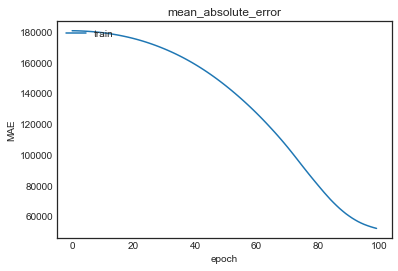

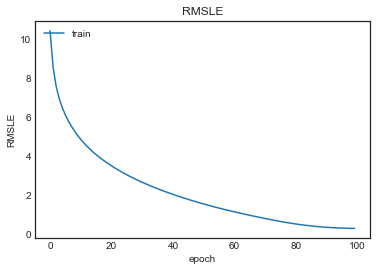

In [347]:
# summarize history for accuracy
plt.plot(history.history['mean_absolute_error'])
plt.title('mean_absolute_error')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('RMSLE')
plt.ylabel('RMSLE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [349]:
# export prediction in Kaggle-required format
pred1s = pd.DataFrame(pred1, columns = ['SalePrice']) 
pred1s = pred1s.assign(Id=test.Id) 
pred1s = pred1s[['Id','SalePrice']] 
pred1s.to_csv('ANN.csv', header = True, index=False) 
pred1s.head()

,Id,SalePrice
0,1461,139059.000000
1,1462,143969.921875
2,1463,149758.203125
3,1464,152338.000000
4,1465,146930.156250


# Non-Neural Network Methods

# K Neighbours Regressor

### knr score = 0.20728

In [180]:
# set up KNR and use random search to optimize parameters
knr_params = {'n_neighbors':range(5,20,5),'algorithm' : ['ball_tree', 'kd_tree'],'leaf_size':range(20,40,10)}
knr = RandomizedSearchCV(KNeighborsRegressor(), knr_params, n_jobs = 4, verbose = 1, cv = 5, 
                         scoring = 'neg_mean_squared_log_error')

In [181]:
# fit KNR
knr.fit(X_arr, y_arr)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   17.5s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   19.4s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'),
          fit_params=None, iid='warn', n_iter=10, n_jobs=4,
          param_distributions={'n_neighbors': range(5, 20, 5), 'algorithm': ['ball_tree', 'kd_tree'], 'leaf_size': range(20, 40, 10)},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_log_error',
          verbose=1)

In [182]:
# show KNR best params and score
print(knr.best_params_, knr.best_score_)

{'n_neighbors': 10, 'leaf_size': 20, 'algorithm': 'ball_tree'} -0.039507057607273875


In [185]:
# save best model
dump(knr.best_estimator_, 'knr_model.joblib')

['knr_model.joblib']

In [186]:
pred_k = knr.best_estimator_.predict(te_X_arr)

In [188]:
# export prediction in Kaggle-required format
pred_knr = pd.DataFrame(pred_k, columns = ['SalePrice']) 
pred_knr = pred_knr.assign(Id=test.Id) 
pred_knr = pred_knr[['Id','SalePrice']] 
pred_knr.to_csv('KNN.csv', header = True, index=False) 
pred_knr.head()

C:\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """


,Id,SalePrice
0,1461,129985.0
1,1462,144050.0
2,1463,183150.0
3,1464,211795.0
4,1465,194600.0


# Support Vector Machine Regression

SVM Score = 0.41838

In [257]:
svm_params = {'kernel':['rbf','poly', 'sigmoid'],'degree':range(1,5,1), 'gamma':['scale','auto'], 'C':range(1,4,1)}
svm_md = RandomizedSearchCV(svm.SVR(), svm_params, n_jobs = 4, verbose = 1, scoring = 'neg_mean_squared_log_error', cv = 5)

In [258]:
svm_md.fit(X_arr, tr_y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   13.5s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   15.8s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=4,
          param_distributions={'kernel': ['rbf', 'poly', 'sigmoid'], 'degree': range(1, 5), 'gamma': ['scale', 'auto'], 'C': range(1, 4)},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_log_error',
          verbose=1)

In [259]:
# show SVM best params and score
print(svm_md.best_params_, svm_md.best_score_)

{'kernel': 'rbf', 'gamma': 'scale', 'degree': 2, 'C': 3} -0.15971052576396708


In [260]:
# save best model
dump(svm_md.best_estimator_, 'svm_model.joblib')

['svm_model.joblib']

In [261]:
# predict test data
pred_s = svm_md.best_estimator_.predict(te_X_arr)

In [262]:
# export prediction in Kaggle-required format
pred_svm = pd.DataFrame(pred_s, columns = ['SalePrice']) 
pred_svm = pred_svm.assign(Id=test.Id) 
pred_svm = pred_svm[['Id','SalePrice']] 
pred_svm.to_csv('SVM.csv', header = True, index=False) 
pred_svm.head()

C:\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """


,Id,SalePrice
0,1461,162954.097242
1,1462,163015.229687
2,1463,163144.827403
3,1464,163186.787202
4,1465,163150.997507


# Linear Support Vector Machine Regression

Linear SVM Score = 0.22005

In [305]:
lsvm_params = {'loss':['epsilon_insensitive','squared_epsilon_insensitive'],'C':range(1,4,1)}
lsvm_md = RandomizedSearchCV(svm.LinearSVR(), lsvm_params, n_jobs = 4, verbose = 1, 
                             scoring = 'neg_mean_squared_log_error', cv = 5)

In [306]:
lsvm_md.fit(X_arr, tr_y)

C:\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    3.2s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0),
          fit_params=None, iid='warn', n_iter=10, n_jobs=4,
          param_distributions={'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'], 'C': range(1, 4)},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_log_error',
          verbose=1)

In [307]:
# show SVM best params and score
print(lsvm_md.best_params_, lsvm_md.best_score_)

{'loss': 'squared_epsilon_insensitive', 'C': 1} -0.02777163957473215


In [308]:
# save best model
dump(lsvm_md.best_estimator_, 'lsvm_model.joblib')

['lsvm_model.joblib']

In [310]:
# predict test data
pred_ls = lsvm_md.best_estimator_.predict(te_X_arr)

In [312]:
# export prediction in Kaggle-required format
pred_lsvm = pd.DataFrame(pred_ls, columns = ['SalePrice']) 
pred_lsvm = pred_lsvm.assign(Id=test.Id) 
pred_lsvm = pred_lsvm[['Id','SalePrice']] 
pred_lsvm.to_csv('LSVM.csv', header = True, index=False) 
pred_lsvm.head()

C:\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """


,Id,SalePrice
0,1461,105210.388885
1,1462,146074.111860
2,1463,178480.103064
3,1464,185368.347541
4,1465,196188.079571


# Ensemble Methods

# Random Forest Regressor

### RF score = 0.16453

In [263]:
# set up random forest regressor
rfr_params = {'n_estimators':range(10,100,10), 'criterion': ['mse','mae'], 'max_depth': range(10,30)}
rf_md = RandomizedSearchCV(RandomForestRegressor(), rfr_params, n_jobs = 4, verbose = 1, 
                           scoring = 'neg_mean_squared_log_error', cv = 5)

In [264]:
rf_md.fit(X_arr, y_arr)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  2.9min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=4,
          param_distributions={'n_estimators': range(10, 100, 10), 'criterion': ['mse', 'mae'], 'max_depth': range(10, 30)},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_log_error',
          verbose=1)

In [265]:
# show RF best params and score
print(rf_md.best_params_, rf_md.best_score_)

{'n_estimators': 60, 'max_depth': 25, 'criterion': 'mae'} -0.021460625202073765


In [266]:
# save best model
dump(rf_md.best_estimator_, 'RF_model.joblib')

['RF_model.joblib']

In [267]:
# predict test data
pred_r = rf_md.best_estimator_.predict(te_X_arr)

In [269]:
# export prediction in Kaggle-required format
pred_rfr = pd.DataFrame(pred_r, columns = ['SalePrice']) 
pred_rfr = pred_rfr.assign(Id=test.Id) 
pred_rfr = pred_rfr[['Id','SalePrice']]  
pred_rfr.to_csv('RFR.csv', header = True, index=False) 
pred_rfr.head()

C:\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """


,Id,SalePrice
0,1461,126387.083333
1,1462,149436.666667
2,1463,173124.166667
3,1464,191472.333333
4,1465,216882.716667


# Bagging Regressor

### Bagging score = 0.16411

In [270]:
# set up bagging regressor
br_params = {'n_estimators':range(10,200,10),}
br_md = RandomizedSearchCV(BaggingRegressor(), br_params, n_jobs = 4, verbose = 1, 
                           scoring = 'neg_mean_squared_log_error', cv = 5)

In [271]:
br_md.fit(X_arr, y_arr)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  1.1min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=None, oob_score=False, random_state=None,
         verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=4,
          param_distributions={'n_estimators': range(10, 200, 10)},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_log_error',
          verbose=1)

In [272]:
# show Bagging best params and score
print(br_md.best_params_, br_md.best_score_)

{'n_estimators': 100} -0.021418235381119453


In [273]:
# save best model
dump(br_md.best_estimator_, 'Bagging_model.joblib')

['Bagging_model.joblib']

In [274]:
# predict test data
pred_b = br_md.best_estimator_.predict(te_X_arr)

In [276]:
# export prediction in Kaggle-required format
pred_bgr = pd.DataFrame(pred_b, columns = ['SalePrice']) 
pred_bgr = pred_bgr.assign(Id=test.Id) 
pred_bgr = pred_bgr[['Id','SalePrice']] 
pred_bgr.to_csv('Bagging.csv', header = True, index=False) 
pred_bgr.head()

C:\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """


,Id,SalePrice
0,1461,132243.25
1,1462,152002.50
2,1463,183639.70
3,1464,199311.32
4,1465,224779.42


# Extra Trees Regressor

### Extra Trees score = 0.16250

In [277]:
# set up extra trees regressor
etr_params = {'n_estimators':range(10,100,10),}
et_md = RandomizedSearchCV(ExtraTreesRegressor(), etr_params, n_jobs = 4, verbose = 1, 
                      scoring = 'neg_mean_squared_log_error', cv = 5)

In [278]:
# fit extra trees
et_md.fit(X_arr, y_arr)

C:\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:   22.7s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
          oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=4,
          param_distributions={'n_estimators': range(10, 100, 10)},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_log_error',
          verbose=1)

In [279]:
# show Extra Trees best params and score
print(et_md.best_params_, et_md.best_score_)

{'n_estimators': 50} -0.020650218251515154


In [281]:
# save best model
dump(et_md.best_estimator_, 'Extra_Trees_model.joblib')

['Extra_Trees_model.joblib']

In [282]:
# predict test data
pred_et = et_md.best_estimator_.predict(te_X_arr)

In [283]:
# export prediction in Kaggle-required format
pred_etr = pd.DataFrame(pred_et, columns = ['SalePrice']) 
pred_etr = pred_etr.assign(Id=test.Id) 
pred_etr = pred_etr[['Id','SalePrice']] 
pred_etr.to_csv('Extra_Trees.csv', header = True, index=False) 
pred_etr.head()

C:\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """


,Id,SalePrice
0,1461,120674.0
1,1462,149854.5
2,1463,164611.8
3,1464,183091.0
4,1465,190266.8


# Ada Boost Regressor

### Ada Boost score = 0.22483

In [287]:
# set up ada boost regressor
abr_params = {'n_estimators':range(10,100,10),'learning_rate' : range(1,3,1),'loss':['linear','square','exponential']}
abr_md = RandomizedSearchCV(AdaBoostRegressor(), abr_params, n_jobs = 4, verbose = 1, 
                            scoring = 'neg_mean_squared_log_error', cv = 5)

In [289]:
# fit model
abr_md.fit(X_arr, y_arr)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    8.3s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=None),
          fit_params=None, iid='warn', n_iter=10, n_jobs=4,
          param_distributions={'n_estimators': range(10, 100, 10), 'learning_rate': range(1, 3), 'loss': ['linear', 'square', 'exponential']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_log_error',
          verbose=1)

In [290]:
# show Ada Boost best params and score
print(abr_md.best_params_, abr_md.best_score_)

{'n_estimators': 60, 'loss': 'exponential', 'learning_rate': 1} -0.03906392271519213


In [291]:
# save best model
dump(abr_md.best_estimator_, 'Ada_Boost_model.joblib')

['Ada_Boost_model.joblib']

In [292]:
# estimate target with model
pred_a = abr_md.best_estimator_.predict(te_X_arr)

In [294]:
# export prediction in Kaggle-required format
pred_abr = pd.DataFrame(pred_a, columns = ['SalePrice']) 
pred_abr = pred_abr.assign(Id=test.Id) 
pred_abr = pred_abr[['Id','SalePrice']] 
pred_abr.to_csv('Ada_Boost.csv', header = True, index=False) 
pred_abr.head()

C:\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """


,Id,SalePrice
0,1461,115191.032468
1,1462,171782.557927
2,1463,189634.502110
3,1464,187302.302326
4,1465,248145.240741


# Gradient Boosting Regressor

### Gradient Boosting score = 0.18172

In [297]:
# set up gradient boosting regressor
gbr_params = {'loss':['ls','lad','huber','quantile'],'n_estimators' : range(100,1000,100),
              'max_depth':range(10,100,10)}
gbr_md = RandomizedSearchCV(GradientBoostingRegressor(), gbr_params, n_jobs = 4, verbose = 1, 
                            scoring = 'neg_mean_squared_log_error', cv = 5)

In [298]:
# fit model
gbr_md.fit(X_arr, y_arr)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  5.5min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  6.3min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=4,
          param_distributions={'loss': ['ls', 'lad', 'huber', 'quantile'], 'n_estimators': range(100, 1000, 100), 'max_depth': range(10, 100, 10)},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_log_error',
          verbose=1)

In [299]:
# show Gradient Boosting best params and score
print(gbr_md.best_params_, gbr_md.best_score_)

{'n_estimators': 700, 'max_depth': 20, 'loss': 'lad'} -0.01925124625487892


In [300]:
# save best model
dump(gbr_md.best_estimator_, 'Gradient_Boosting_model.joblib')

['Gradient_Boosting_model.joblib']

In [301]:
# estimate target with model
pred_g = gbr_md.best_estimator_.predict(te_X_arr)

In [302]:
# export prediction in Kaggle-required format
pred_gbr = pd.DataFrame(pred_g, columns = ['SalePrice']) 
pred_gbr = pred_gbr.assign(Id=test.Id) 
pred_gbr = pred_gbr[['Id','SalePrice']] 
pred_gbr.to_csv('GB.csv', header = True, index=False) 
pred_gbr.head()

C:\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """


,Id,SalePrice
0,1461,147889.323181
1,1462,177248.268955
2,1463,187662.392849
3,1464,205955.682166
4,1465,197693.714878


# LightGBM

### LGBM score = 0.13451 (Highest)

In [313]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(tr_X, label = tr_y)

In [314]:
# specify configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmsle',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
}

In [315]:
# train LGBM model
x_train, x_valid, y_train, y_valid = train_test_split(tr_X, tr_y, test_size=0.10)
d_train = lgb.Dataset(x_train, label=y_train)
d_valid = lgb.Dataset(x_valid, label=y_valid)

model = lgb.train(params, d_train, verbose_eval=1)

pred_l = model.predict(te_X)

In [318]:
# export data
pred_lgb = pd.DataFrame(pred_l, columns = ['SalePrice']) 
pred_lgb = pred_lgb.assign(Id=test.Id) 
pred_lgb = pred_lgb[['Id','SalePrice']] 
pred_lgb.to_csv('LGBM.csv', header = True, index=False) 
pred_lgb.head()

,Id,SalePrice
0,1461,120133.696839
1,1462,155603.037625
2,1463,183119.234876
3,1464,193023.212222
4,1465,193827.966182


#  Ensemble Learning

### Ensemble score = 0.15087

In [321]:
# attach it to a numpy array
final_pred = np.array([])
for i in range(0,len(te_X)):
    final_pred = np.append(final_pred, np.median([pred_r[i], pred_b[i], pred_g[i], pred_et[i], pred_l[i]]))

In [322]:
# export to csv
pred = pd.DataFrame(final_pred, columns = ['SalePrice'])
pred = pred.assign(Id=te_X.iloc[:,0])
pred = pred[['Id','SalePrice']]
pred.Id = pred.Id.astype('int')
pred.SalePrice = pd.to_numeric(pred.SalePrice)
pred.to_csv('prediction.csv', header = True, index=False)

In [323]:
# show first 5 rows of prediction
pred.head()

,Id,SalePrice
0,1461,126387.083333
1,1462,152002.500000
2,1463,183119.234876
3,1464,193023.212222
4,1465,197693.714878


C:\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


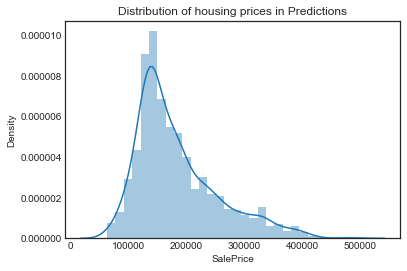

In [324]:
# plot distribution of Target in train dataset
style.use('seaborn-white')
sns.distplot(pred.SalePrice, kde=True, norm_hist = True)
plt.ylabel('Density')
plt.title('Distribution of housing prices in Predictions')
plt.show()